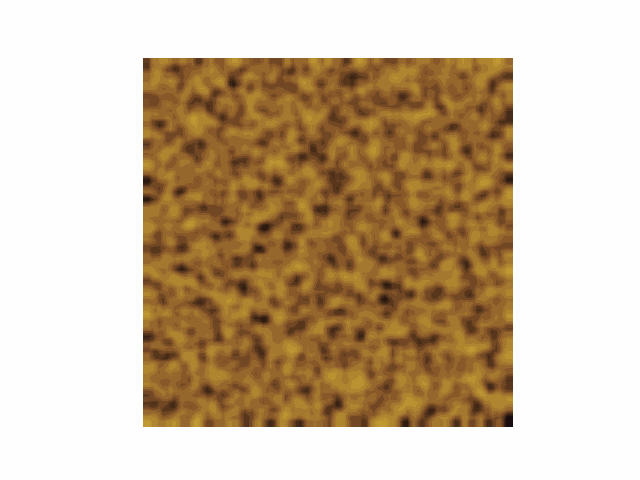

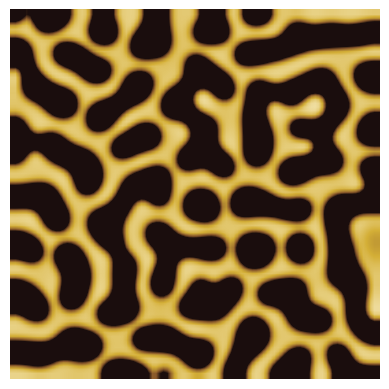

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image

# Parametry
a = 2.8e-4
b = 5e-3
tau = 0.1
k = -0.005
size = 100
dx = 2.0 / size
dt = 0.001

# Inicjalizacja
U = np.random.rand(size, size)
V = np.random.rand(size, size)

# Definicja gepardziej palety
cheetah_colors = ["#1a0d0d", "#8b5a2b", "#d4af37", "#fff8dc"]  
cheetah_cmap = LinearSegmentedColormap.from_list("cheetah", cheetah_colors)

# Przygotowanie figury
fig, ax = plt.subplots()
im = ax.imshow(U, cmap=cheetah_cmap, interpolation='bilinear', animated=True)
ax.axis('off')

def laplacian(Z):
    return (
        Z[:-2, 1:-1] + Z[2:, 1:-1] +
        Z[1:-1, :-2] + Z[1:-1, 2:] -
        4 * Z[1:-1, 1:-1]
    ) / dx**2

# def update(frame, U, V):
#     for _ in range(250):
#         deltaU = laplacian(U)
#         deltaV = laplacian(V)
#         Uc, Vc = U[1:-1, 1:-1], V[1:-1, 1:-1]
#         U[1:-1, 1:-1] = Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k)
#         V[1:-1, 1:-1] = Vc + dt * (b * deltaV + Uc - Vc) / tau
#         for Z in (U, V):
#             Z[0, :] = Z[1, :]
#             Z[-1, :] = Z[-2, :]
#             Z[:, 0] = Z[:, 1]
#             Z[:, -1] = Z[:, -2]
#     im.set_array(U)
#     return [im]

color_counts_over_time = []

def indexed_colormap(U_frame, cmap, bins=4):

    normed_U = (U_frame - U_frame.min())/(U_frame.max() - U_frame.min())
    indices = np.floor(normed_U*bins).astype(int)
    indices[indices == bins] = bins - 1 
    return indices

def update(frame, U, V):
    for _ in range(250):
        deltaU = laplacian(U)
        deltaV = laplacian(V)
        Uc, Vc = U[1:-1, 1:-1], V[1:-1, 1:-1]
        U[1:-1, 1:-1] = Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k)
        V[1:-1, 1:-1] = Vc + dt * (b * deltaV + Uc - Vc) / tau
        for Z in (U, V):
            Z[0, :] = Z[1, :]
            Z[-1, :] = Z[-2, :]
            Z[:, 0] = Z[:, 1]
            Z[:, -1] = Z[:, -2]

    im.set_array(U)
    
    color_indices = indexed_colormap(U, cheetah_cmap)
    counts = np.bincount(color_indices.ravel(), minlength=4)
    color_counts_over_time.append(counts)
    
    # Zapisz obraz po ostatniej klatce
    if frame == 99:  # Ostatnia klatka (100 klatek, indeksowanie od 0)
        plt.savefig("final_cheetah_fur.png", dpi=300, bbox_inches='tight')

    return [im]

ani = FuncAnimation(fig, update, frames=100, blit=True, fargs=(U, V))
ani.save("turing_animation.gif", writer=PillowWriter(fps=7))
Image(filename='turing_animation.gif')

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
image1 = cv2.imread('final_cheetah_fur.png')
image2 = cv2.imread('cheetah_image.jpg')

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

hist1 = cv2.calcHist([gray1], [0], None, [256], [0, 256])
hist2 = cv2.calcHist([gray2], [0], None, [256], [0, 256])
similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
print("Histogram similarity (correlation):", similarity)


Histogram similarity (correlation): 0.15806862172157038


In [48]:
orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

print("ORB match score (lower is better):", np.mean([m.distance for m in matches]))


ORB match score (lower is better): 53.13333333333333


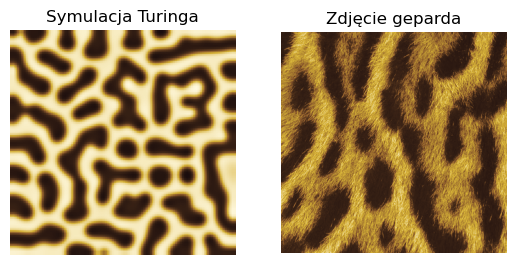

In [49]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Konwertuj na skalę szarości
gray_cheetah = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY).astype(float)

# Normalizuj do 0–1
gray_cheetah_norm = (gray_cheetah - gray_cheetah.min()) / (gray_cheetah.max() - gray_cheetah.min())

# Użyj tej samej palety koloru
mapped = cheetah_cmap(gray_cheetah_norm)

# Zamiana na obraz (0–255, uint8)
mapped_img = (mapped[:, :, :3] * 255).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.title("Symulacja Turinga")
plt.imshow(U, cmap=cheetah_cmap)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Zdjęcie geparda")
plt.imshow(gray_cheetah_norm, cmap=cheetah_cmap)
plt.axis('off')

plt.show()


In [50]:
# Histogram RGB z przemapowanych obrazów
hist1 = cv2.calcHist([cv2.cvtColor((U * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)], [0, 1, 2], None, [8,8,8], [0,256]*3)
hist2 = cv2.calcHist([mapped_img], [0, 1, 2], None, [8,8,8], [0,256]*3)

# Normalizacja
hist1 = cv2.normalize(hist1, hist1).flatten()
hist2 = cv2.normalize(hist2, hist2).flatten()

# Porównanie korelacją
similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
print("Histogram similarity (correlation):", similarity)


Histogram similarity (correlation): -0.01568506320848413


In [51]:
orb = cv2.ORB_create()

# Detekcja kluczowych punktów i deskryptorów
kp1, des1 = orb.detectAndCompute((U * 255).astype(np.uint8), None)
kp2, des2 = orb.detectAndCompute(cv2.cvtColor(mapped_img, cv2.COLOR_RGB2GRAY), None)

# Matcher i dopasowanie
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Oblicz średnią odległość (im mniejsza, tym lepiej)
score = np.mean([m.distance for m in matches]) if matches else float('inf')
print("ORB match score (lower is better):", score)


ORB match score (lower is better): 81.93650793650794
